In [51]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [52]:
data_2016 = pd.read_csv('2016.csv')
data_2017 = pd.read_csv('2017.csv')
data_2018 = pd.read_csv('2018.csv')
data_2019 = pd.read_csv('2019.csv')
data_2020 = pd.read_csv('2020.csv')

In [53]:
combined_data = pd.concat([data_2016, data_2017, data_2018, data_2019, data_2020])
combined_data = combined_data[['Date', 'Close']]
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

In [54]:
combined_data.head()

,Close
Date,
2016-01-01,7963.20
2016-01-04,7791.30
2016-01-05,7784.65
2016-01-06,7741.00
2016-01-07,7568.30


### Visualizing Share Market data

In [55]:
y = combined_data.resample('MS').mean()

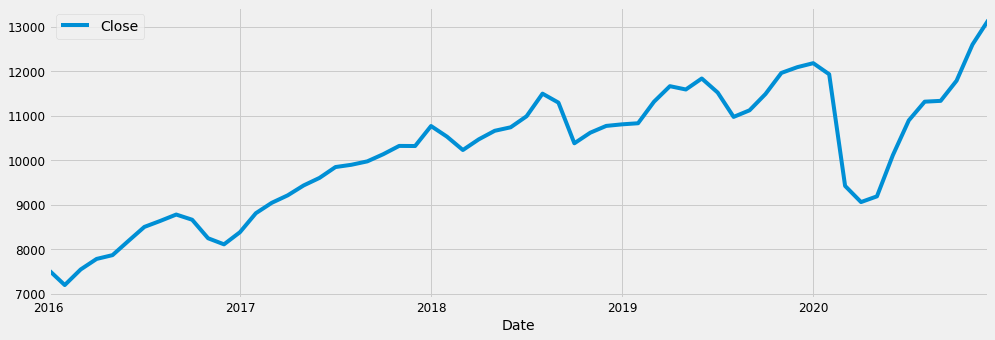

In [56]:
y.plot(figsize=(15, 5))

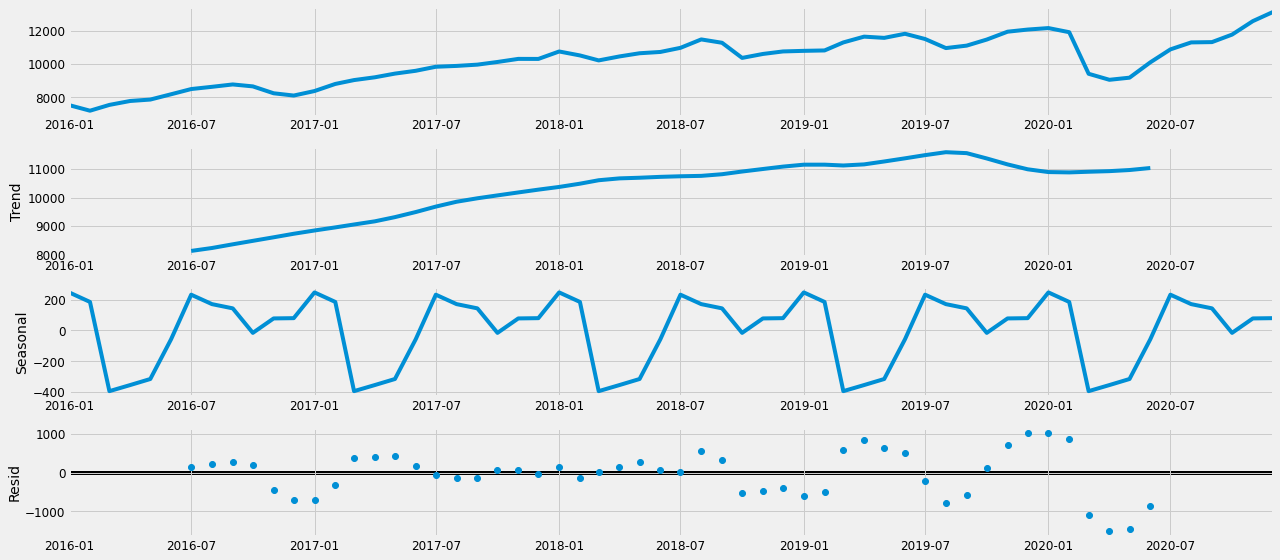

In [57]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Timeseries forecasting using ARIMA

In [58]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1260.0570384883226
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:982.010922223138
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:811.065529356321
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1480.3451605736755
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:816.4550026716961
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:795.7319515710327
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:614.5107261275571
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1051.0613273590427
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1200.1946330326973
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:947.221733860069
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:751.3738779973055
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2718.5432210323097
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:782.0116677277472
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:741.6792561345355
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:587.6127301063515
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2788.2144528642966
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:883.0848492031224
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:709.0385468848785
ARIMA(0

In [60]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2685      0.334      0.803      0.422      -0.387       0.924
ar.S.L12      -0.8961      0.167     -5.352      0.000      -1.224      -0.568
sigma2      3.262e+05   4.79e+04      6.814      0.000    2.32e+05     4.2e+05


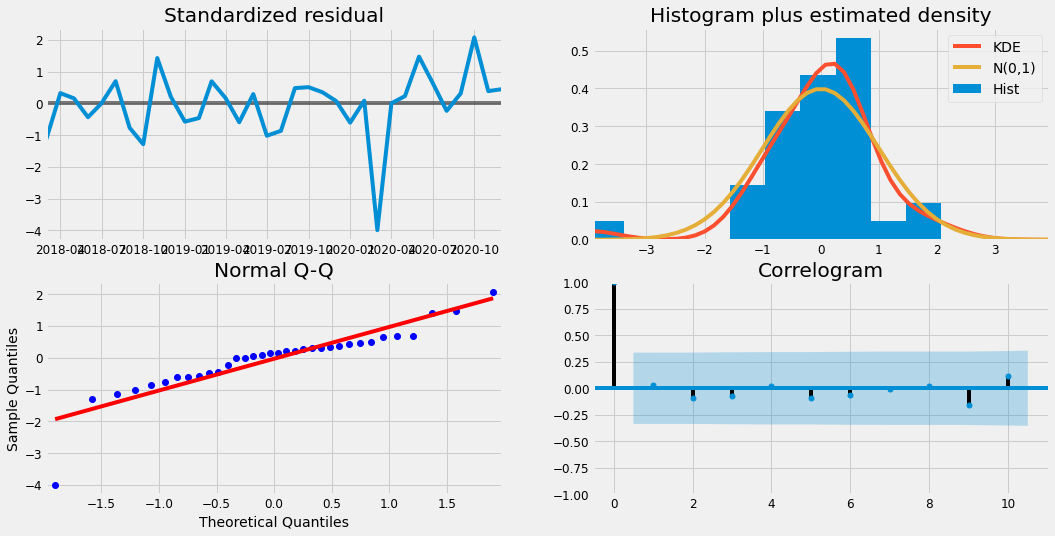

In [61]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

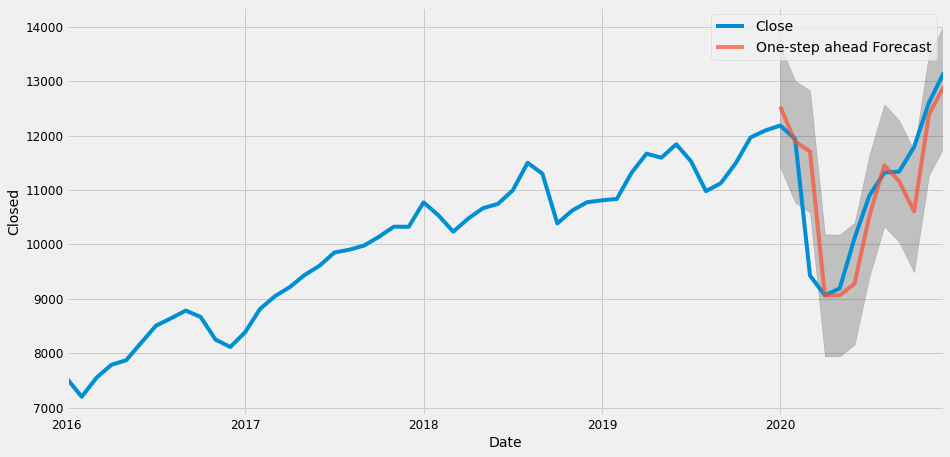

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closed')
plt.legend()
plt.show()

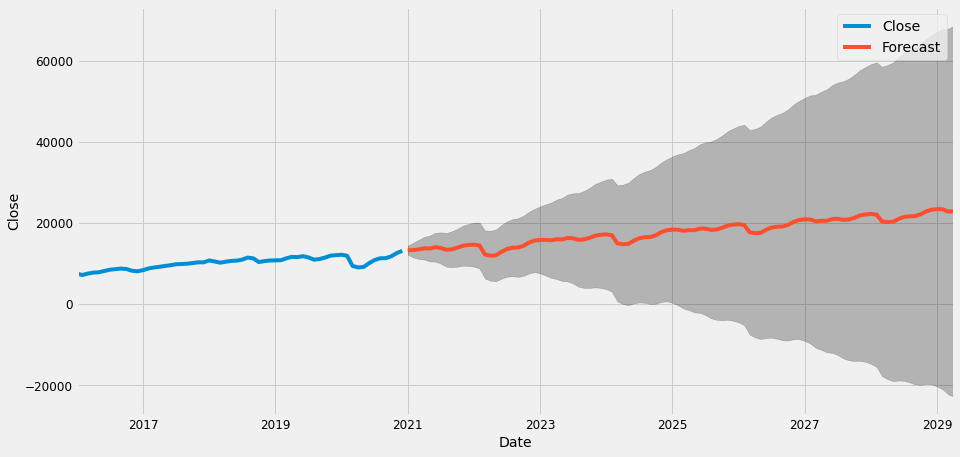

In [66]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()